In [23]:
#Import the Library
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, ZeroPadding2D , Conv2D, MaxPooling2D, BatchNormalization,Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import itertools
import tensorflow as tf

In [2]:
#set the parameters
IMAGE_SIZE = [224, 224]
epochs = 16
batch_size = 128

In [3]:
#donwload the dataset o Blood Celss
!wget -nc https://archive.org/download/blood_cell_images/blood_cell_images.zip
!unzip -nq blood_cell_images.zip


--2024-09-23 07:02:32--  https://archive.org/download/blood_cell_images/blood_cell_images.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip [following]
--2024-09-23 07:02:33--  https://ia801204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip
Resolving ia801204.us.archive.org (ia801204.us.archive.org)... 207.241.228.24
Connecting to ia801204.us.archive.org (ia801204.us.archive.org)|207.241.228.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M   436KB/s    in 5m 37s  

2024-09-23 07:08:11 (319 KB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [4]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [5]:
# Localized path of the data
train_path = 'blood_cell_images/TRAIN'
valid_path ='blood_cell_images/TEST'

In [6]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files =glob(valid_path + '/*/*.jp*g')

In [7]:
folders = glob(train_path + '/*')


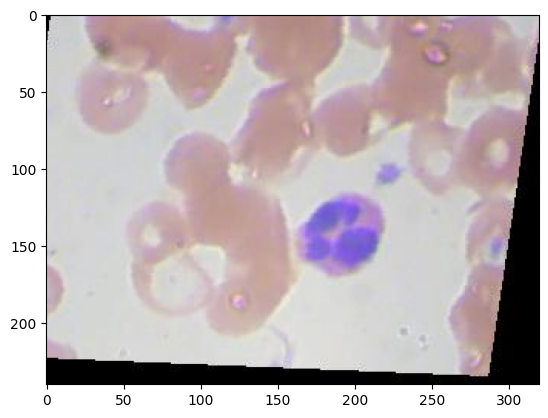

In [8]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [9]:
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1),
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    x = add([x, input_])
    x = Activation('relu')(x)
    return x

In [10]:
def conv_block(input_,
               kernel_size,
               filters,
               strides=(2, 2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides,
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides,
                      kernel_initializer='he_normal'
    )(input_)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [11]:
i = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7,7),
           strides = (2,2),
           padding = 'valid',
           kernel_initializer ='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3,3), strides = (2,2)) (x)

x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

In [12]:
x = Flatten()(x)
prediction= Dense(len(folders), activation='softmax')(x)

In [13]:
model = Model(inputs=i, outputs = prediction)

In [14]:
model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x7a39cc372110>>

In [15]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [16]:
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input2
)

In [17]:
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -1.0 max: 0.9607843


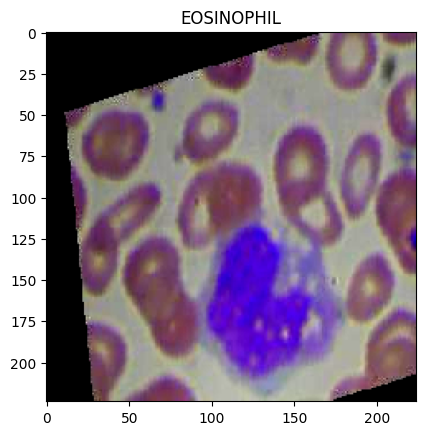

In [18]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [19]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size,
    class_mode = 'sparse'
)
valid_generator = val_gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    shuffle = False,
    batch_size=batch_size,
    class_mode = 'sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [25]:
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps = len(valid_image_files)//batch_size,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(
            monitor ='loss', patience =3, restore_best_weights = True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_filepath,
            save_weights_only = True,
            monitor = ' val_accuracy',
            mode ='max',
            save_best_only=True),
    ]
)

Epoch 1/16
77/77 [==============================] - ETA: 0s - loss: 8.0093 - accuracy: 0.2915

77/77 [==============================] - 181s 2s/step - loss: 8.0093 - accuracy: 0.2915 - val_loss: 3.9005 - val_accuracy: 0.2664
Epoch 2/16
77/77 [==============================] - ETA: 0s - loss: 2.2834 - accuracy: 0.4315

77/77 [==============================] - 155s 2s/step - loss: 2.2834 - accuracy: 0.4315 - val_loss: 2.7988 - val_accuracy: 0.3121
Epoch 3/16
77/77 [==============================] - ETA: 0s - loss: 1.9872 - accuracy: 0.6006

77/77 [==============================] - 155s 2s/step - loss: 1.9872 - accuracy: 0.6006 - val_loss: 2.7802 - val_accuracy: 0.3573
Epoch 4/16
77/77 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.7645

77/77 [==============================] - 156s 2s/step - loss: 0.7866 - accuracy: 0.7645 - val_loss: 2.6367 - val_accuracy: 0.4285
Epoch 5/16
77/77 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.8377

77/77 [==============================] - 155s 2s/step - loss: 0.5584 - accuracy: 0.8377 - val_loss: 1.7791 - val_accuracy: 0.6336
Epoch 6/16
77/77 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8937

77/77 [==============================] - 154s 2s/step - loss: 0.3475 - accuracy: 0.8937 - val_loss: 1.1242 - val_accuracy: 0.7792
Epoch 7/16
77/77 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.9073

77/77 [==============================] - 157s 2s/step - loss: 0.3311 - accuracy: 0.9073 - val_loss: 0.9333 - val_accuracy: 0.7919
Epoch 8/16
77/77 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.9085

77/77 [==============================] - 156s 2s/step - loss: 0.3894 - accuracy: 0.9085 - val_loss: 1.6160 - val_accuracy: 0.8183
Epoch 9/16
77/77 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.9332

77/77 [==============================] - 156s 2s/step - loss: 0.2865 - accuracy: 0.9332 - val_loss: 3.3680 - val_accuracy: 0.7216
Epoch 10/16
77/77 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.9314

77/77 [==============================] - 158s 2s/step - loss: 0.3277 - accuracy: 0.9314 - val_loss: 2.2529 - val_accuracy: 0.7915
Epoch 11/16
77/77 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.9419

77/77 [==============================] - 154s 2s/step - loss: 0.3097 - accuracy: 0.9419 - val_loss: 1.5194 - val_accuracy: 0.8495
Epoch 12/16
77/77 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9569

77/77 [==============================] - 160s 2s/step - loss: 0.1913 - accuracy: 0.9569 - val_loss: 1.2875 - val_accuracy: 0.8454
Epoch 13/16
77/77 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9492

77/77 [==============================] - 156s 2s/step - loss: 0.2683 - accuracy: 0.9492 - val_loss: 1.9852 - val_accuracy: 0.8096
Epoch 14/16
77/77 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.9434

77/77 [==============================] - 156s 2s/step - loss: 0.3334 - accuracy: 0.9434 - val_loss: 1.1223 - val_accuracy: 0.8721
Epoch 15/16
77/77 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9641

77/77 [==============================] - 157s 2s/step - loss: 0.1853 - accuracy: 0.9641 - val_loss: 1.4456 - val_accuracy: 0.8725
Epoch 16/16
77/77 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9715

77/77 [==============================] - 161s 2s/step - loss: 0.1266 - accuracy: 0.9715 - val_loss: 2.6549 - val_accuracy: 0.8059


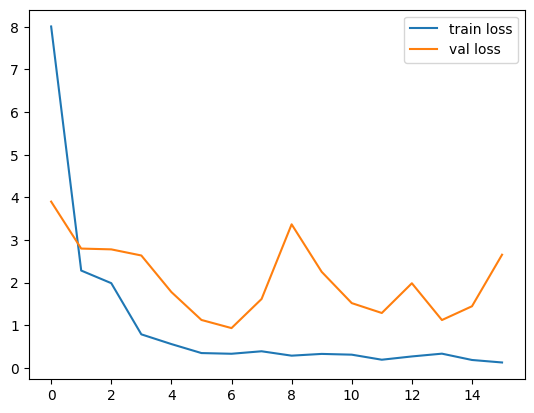

In [26]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

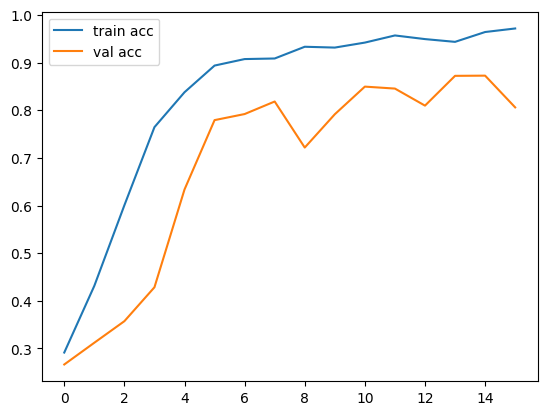

In [27]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [30]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [31]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
8/8 [==============================] - 1s 128ms/step
[[2311    0    0  186]
 [  11 2439    0   33]
 [  39    0 2327  112]
 [  33    0    0 2466]]


In [32]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
6/6 [==============================] - 1s 215ms/step
[[455   0   0 168]
 [ 47 498  29  46]
 [  0   0 465 155]
 [ 29   0   0 595]]


In [33]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[2311    0    0  186]
 [  11 2439    0   33]
 [  39    0 2327  112]
 [  33    0    0 2466]]


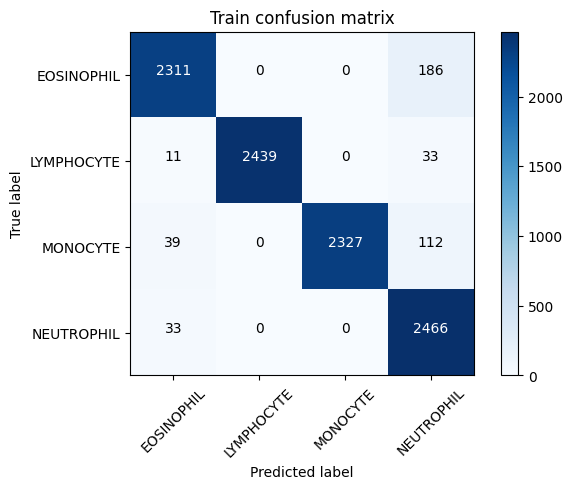

In [34]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

In [35]:
np.trace(cm) / cm.sum()

0.9584212112081952

Confusion matrix, without normalization
[[455   0   0 168]
 [ 47 498  29  46]
 [  0   0 465 155]
 [ 29   0   0 595]]


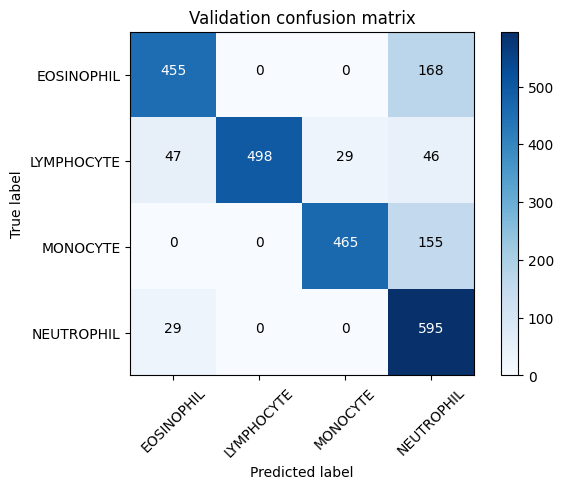

In [36]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [37]:
np.trace(valid_cm) / valid_cm.sum()

0.8094089264173703

In [38]:
# Save the model after training
model.save('path_to_save_model/my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
